In [5]:
# Data processing/formatting
from sklearn.preprocessing import MinMaxScaler
from seqprops import SequentialPropertiesEncoder
from sklearn.model_selection import train_test_split

# for building vae model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, LSTM, Bidirectional, Conv1D, Dropout, RepeatVector, TimeDistributed, Lambda
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

# classic required packages
import os
import random
import pandas as pd
import numpy as np
from pylab import rcParams
import importlib
import importlib.resources

# packages for graphics
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
file = 'amp.csv'
df = pd.read_csv(file)
# sequences = pd.read_csv(file, usecols=['sequence']).iloc[:, 0].values
# sequence_type = pd.read_csv(file, usecols=['label']).iloc[:, 0].values

sequences = df.loc[:, 'sequence'].values
sequences_type = df.loc[:, 'label'].values
print(sequences)
print(sequences_type)

# Determine the length of the longest sequence
max_seq_len = 0
for sequence in sequences:
    max_seq_len = max(len(sequence), max_seq_len)
print("Max sequence length: ", max_seq_len)

['GEP' 'QHP' 'YLRF' ...
 'MGSPEKLRPSDFSKSFLISSIRFAMSFSSFELYSACSSLIRVSSPTMAET'
 'MLLPATMSDKPDMAEIEKFDKSKLKKTETQEKNPLPSKETIEQEKQAGES'
 'GATIKKCVVDVKLSKPCTFQECQPLCLQKYNGNGLCPGDDNNICACVYNC']
[0 0 0 ... 0 0 1]
Max sequence length:  50


In [7]:
df['label'].value_counts()

0    5701
1    3708
Name: label, dtype: int64

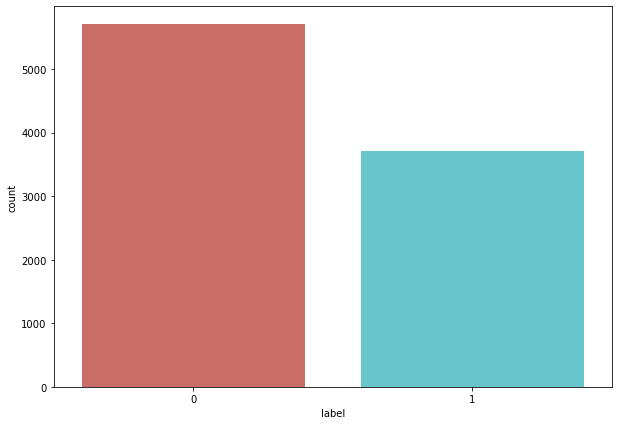

<Figure size 720x504 with 0 Axes>

In [8]:
rcParams['figure.figsize'] =  10,7
sns.countplot(x = 'label', data=df, palette='hls')
plt.show()
plt.savefig('count_plot')

In [9]:
### TRAIN TEST SPLIT ###
encoder = SequentialPropertiesEncoder(scaler=MinMaxScaler(feature_range=(-1, 1)), max_seq_len=max_seq_len - 1, stop_signal=True)
all_seq_encoded = encoder.encode(sequences)
print("Shape of all sequences: ", all_seq_encoded.shape)
print("----------------------------")
train_size = 0.8

# One way
sequence_input_train = all_seq_encoded[:int(len(all_seq_encoded) * train_size)]
sequence_input_test = all_seq_encoded[int(len(all_seq_encoded) * train_size):]
print(sequence_input_train.shape, sequence_input_test.shape)
# print(sequence_input_train)

sequence_target_train = sequences_type[:int(len(sequences_type) * train_size)]
sequence_target_test = sequences_type[int(len(sequences_type) * train_size):]

print("----------------------------")
# Second way
# Iz nekog razloga ako napravim ovo ne uci dobro
(x_train, x_test, y_train, y_test) = train_test_split(all_seq_encoded, sequences_type, test_size=0.2, random_state=42)

print(x_train.shape)
# print(x_train)
print(x_test.shape)

print("----------------------------")
# shape for Encoder input 
shape = x_train.shape[1:]
print(shape)

Shape of all sequences:  (9409, 50, 95)
----------------------------
(7527, 50, 95) (1882, 50, 95)
----------------------------
(7527, 50, 95)
(1882, 50, 95)
----------------------------
(50, 95)


In [74]:
# encoder model definition
def create_seq_encoder_model(input_shape, latent_dim=2, lstm_cells=64):
    inp = Input(shape=input_shape, name="input_1_enc")
    
#     vratit unroll = True
    x = LSTM(lstm_cells, unroll=True, name="lstm_enc")(inp)
#     vratit Dense na 16
    z = Dense(32, activation='relu', name="output_dense_enc")(x)
    z_mean = Dense(latent_dim)(z)
    z_log_sigma = Dense(latent_dim)(z)
    
    encoder_model = Model(inputs=inp, outputs=[z_mean, z_log_sigma], name="encoder")
    return encoder_model

In [75]:
# decoder model definition
def create_seq_decoder_model(input_shape, latent_dim=2, lstm_cells=64):
    model_input = Input(shape=(latent_dim,), name="input_1_dec")
    x = RepeatVector(input_shape[0])(model_input)
#     vratit unroll = True
    x = LSTM(lstm_cells, unroll=True, name="lstm_dec", return_sequences=True)(x)
#   applies layer for every temporal slice of an input - feature
#   activation='linear'
    out = TimeDistributed(Dense(input_shape[1]))(x)
    
    decoder_model = Model(inputs=model_input, outputs=out, name="decoder")
    return decoder_model

In [76]:
# setting latent space to 2 dimension
latent_dim = 2
sequence_length = 50
# setting fixed randomizer
def set_seed(seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)

# sampling from latent space
def sampling(args):
    
    z_mean, z_log_sigma = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_sigma) * epsilon

# loss function defined from reconstruction param and regularisation term (expressed as the Kulback-Leibler (KL) divergence)
def vae_loss(inp, reconstruction, z_log_sigma, z_mean):
#     OLD
#     kl_loss = tf.reduce_mean(-0.5 * tf.reduce_sum(1 + z_log_sigma - tf.square(z_mean) - tf.exp(z_log_sigma), axis=1))
#     reconstruction_loss = tf.reduce_mean(
#                 tf.reduce_sum(
#                     keras.losses.mean_squared_error(inp, reconstruction), axis=1
#                 )
#             )
    reconstruction_loss = K.mean(K.square(inp - reconstruction)) * sequence_length
    kl_loss = -0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma))
    
    return reconstruction_loss + kl_loss
        

def get_model():
    
    set_seed(31)
    
    ### encoder ###
    encoder = create_seq_encoder_model(input_shape=shape)  # shape (Time Steps, Features)
    encoder.summary()

    ### decoder ###
    decoder = create_seq_decoder_model(input_shape=shape, latent_dim=2)
    decoder.summary()

    ### encoder + decoder ###
    inp = Input(shape=shape, name="vae_encoder_input")
    z_mean, z_log_sigma = encoder(inp)
    z = Lambda(sampling)([z_mean, z_log_sigma])
     
    reconstruction = decoder(z)
    
    vae = Model(inp, reconstruction, name="vae_model")
    vae.add_loss(vae_loss(inp, reconstruction, z_log_sigma, z_mean))
    vae.compile(loss=None, optimizer=keras.optimizers.Adam(learning_rate=1e-3))
    
    return vae, encoder, decoder

In [94]:
es = EarlyStopping(patience=5, verbose=1, min_delta=0.01, monitor='loss', mode='auto', restore_best_weights=True)
vae, enc, dec = get_model()
# mnogi fitaju tu dva put - sequence_input_train (dal je to radi greske il ne)
# https://blog.keras.io/building-autoencoders-in-keras.html

# vae.fit(sequence_input_train, batch_size=128, epochs=100, validation_data=(sequence_input_test, None), shuffle=False, callbacks=[es])

vae.fit(sequence_input_train, batch_size=128, epochs=100, validation_split=0.2, shuffle=False, callbacks=[es])

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1_enc (InputLayer)       [(None, 50, 95)]     0           []                               
                                                                                                  
 lstm_enc (LSTM)                (None, 64)           40960       ['input_1_enc[0][0]']            
                                                                                                  
 output_dense_enc (Dense)       (None, 32)           2080        ['lstm_enc[0][0]']               
                                                                                                  
 dense_42 (Dense)               (None, 2)            66          ['output_dense_enc[0][0]']       
                                                                                            

In [96]:
### LATENT REPRESENTATION ON TEST DATA ###

enc_pred, _ = enc.predict(sequence_input_test)
# enc_pred, _ = enc.predict(x_test, batch_size=128)
print(enc_pred.shape)
print(enc_pred)

print(sequence_target_test)

59/59 [==============================] - 1s 16ms/step
(1882, 2)
[[-0.00612477 -0.00371138]
 [ 0.00981628  0.02261641]
 [ 0.00996033  0.01362154]
 ...
 [-0.07904325  0.03736558]
 [ 0.01583586 -0.005225  ]
 [-0.02722157 -0.14094515]]
[1 0 1 ... 0 0 1]


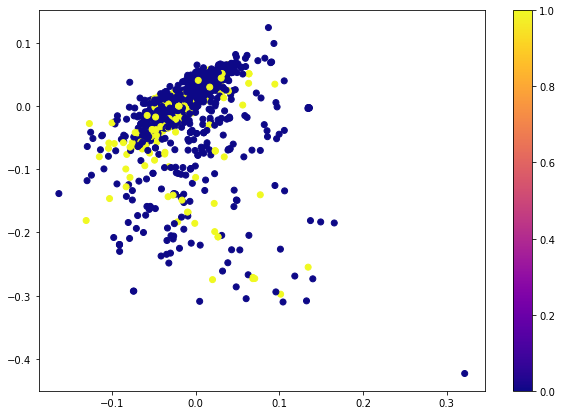

In [97]:
plt.scatter(enc_pred[:,0], enc_pred[:,1], c=sequence_target_test ,cmap='plasma')
# plt.scatter(enc_pred[:,0], enc_pred[:,1], c=y_test ,cmap='plasma')
plt.colorbar()
plt.show()

59/59 [==============================] - 1s 15ms/step


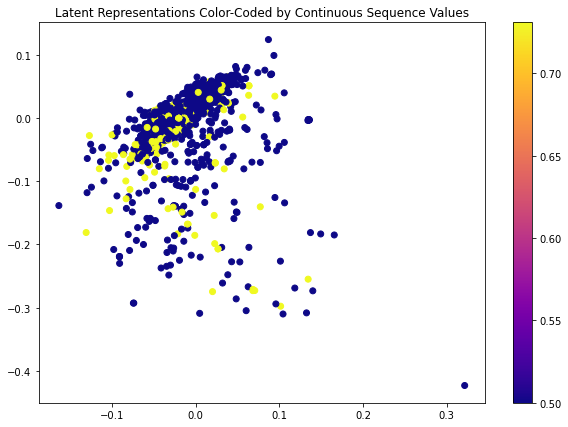

In [98]:
# Map binary values to a continuous range using the sigmoid function
continuous_sequence = 1 / (1 + np.exp(-sequence_target_test))

# Encode the test data using the trained encoder
enc_pred, _ = enc.predict(sequence_input_test)

# Plot the latent representations, color-coded by the continuous sequence values
plt.scatter(enc_pred[:, 0], enc_pred[:, 1], c=continuous_sequence, cmap='plasma', marker='o')
plt.title('Latent Representations Color-Coded by Continuous Sequence Values')
plt.colorbar()
plt.show()

59/59 [==============================] - 1s 15ms/step
[[-0.00612477 -0.00371138]
 [ 0.00981628  0.02261641]
 [ 0.00996033  0.01362154]
 ...
 [-0.07904325  0.03736558]
 [ 0.01583586 -0.005225  ]
 [-0.02722157 -0.14094515]]
59/59 [==============================] - 1s 14ms/step
[[-0.00344714  0.00870059]
 [-0.00355188  0.00864132]
 [-0.00351189  0.00865979]
 ...
 [-0.00370466  0.00862886]
 [-0.0034235   0.00869746]
 [-0.00282334  0.00902458]]


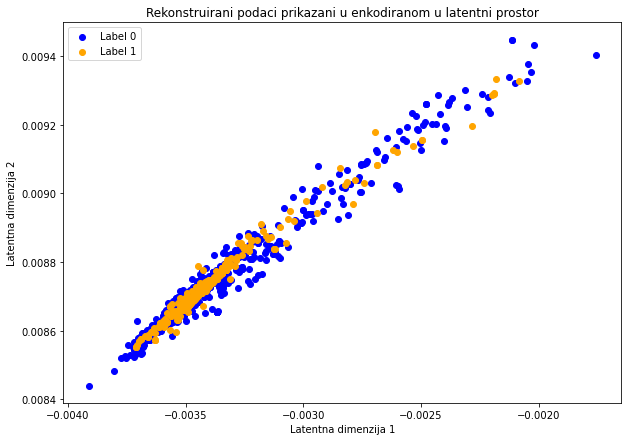

In [99]:
def plot_reconstructed_data(encoder, decoder, x_data, y_data):
    z_input, _ = encoder.predict(x_data)
    
    print(z_input)
    
    reconstructed_input = decoder.predict(z_input)
    reconstruced_z_input, _ = encoder.predict(reconstructed_input)
    
    print(reconstruced_z_input)
    
    unique_labels = np.unique(y_data)
    label_colors = ['blue', 'orange']
    
    for label in unique_labels:
        indices = np.where(y_data == label)[0]
        plt.scatter(reconstruced_z_input[indices, 0], reconstruced_z_input[indices, 1], 
                    c=label_colors[label], label=f'Label {label}')

    plt.xlabel("Latentna dimenzija 1")
    plt.ylabel("Latentna dimenzija 2")
    plt.title("Rekonstruirani podaci prikazani u enkodiranom u latentni prostor")
    plt.legend()
    plt.show()
    
plot_reconstructed_data(enc, dec, sequence_input_test, sequence_target_test)